<a href="https://colab.research.google.com/github/M-Nitsche/BeeWatch/blob/main/object_detection/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 28918, done.
remote: Counting objects: 100% (1462/1462), done.
remote: Compressing objects: 100% (489/489), done.
remote: Total 28918 (delta 1063), reused 1289 (delta 946), pack-reused 27456
Receiving objects: 100% (28918/28918), 37.39 MiB | 9.42 MiB/s, done.
Resolving deltas: 100% (21677/21677), done.
Checking out files: 100% (560/560), done.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/android/scripts/install_gradle.sh
	.circleci/unittest/ios/scripts/binary_ios_build.sh
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	android/gradlew
	ios/VisionTestApp/clean.sh
	ios/VisionTestApp/setup.sh
	ios/build_ios.sh
	packaging/build

In [29]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [30]:
import torch
from torchvision import datasets, transforms
import torch.utils.data
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import helper

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import os
import os.path as path
import xml.etree.ElementTree as ET

## Setup directories

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    is_colab = True

    from google.colab import drive
    cwdir = "drive/My Drive"
    drive.mount("/content/drive")
    os.chdir(cwdir)

    synthetic_data_dir = "./data/synthetic_data"
else:
    print('Not running on CoLab')
    is_colab = False
    
    if os.path.basename(os.path.normpath(os.getcwd())) != "BeeWatch":
        os.chdir('..')
        cw_dir = os.getcwd()
        
    synthetic_data_dir = "./dataset/synthetic_data"

    
annotation_path = path.join(synthetic_data_dir, "annots")
images_path = path.join(synthetic_data_dir, "images")

print(f"Working directory set to: {os.getcwd()}")
print(f"Annotations directory: {annotation_path}")
print(f"Images diectory: {images_path}")

Running on CoLab
Mounted at /content/drive
Working directory set to: /content/drive/My Drive
Annotations directory: ./data/synthetic_data/annots
Images diectory: ./data/synthetic_data/images


## Visualize example image object detection

**Load example image**

In [3]:
example_image = Image.open(path.join(images_path, "0.jpg"))

**Load example annotation**

In [5]:
def read_annotation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

name, boxes = read_annotation(path.join(annotation_path, "0.xml"))

In [6]:
boxes[0]

[753, 239, 797, 283]

**Visualize Bounding Boxes and Image**

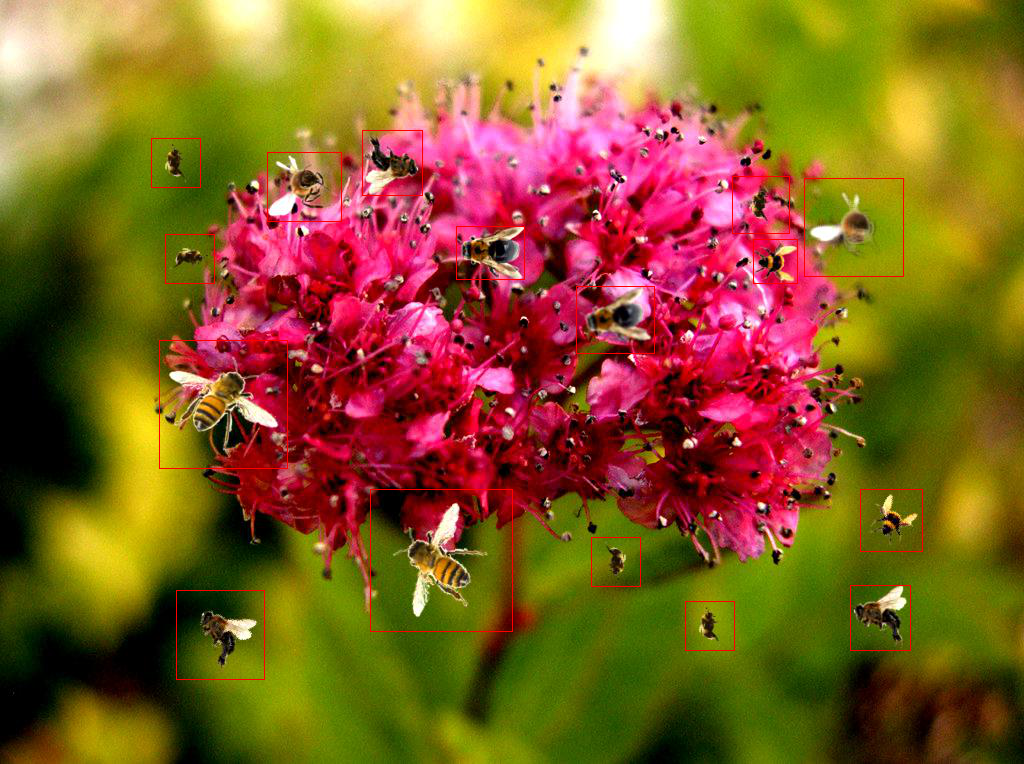

In [7]:
draw = ImageDraw.Draw(example_image)
for bb in boxes:
    draw.rectangle([(bb[0], bb[1]), (bb[2], bb[3])], outline ="red")
example_image

## Create Dataset Object

In [8]:
class BeeDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_imgs=images_path, path_to_annots=annotation_path, transforms=None):
        self.path_to_imags = path_to_imgs
        self.path_to_annots = path_to_annots
        self.image_ids = sorted(os.listdir(images_path))
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = os.path.splitext(self.image_ids[idx])[0]
        img = Image.open(os.path.join(self.path_to_imags, img_id + ".jpg"))
        _, bboxes = read_annotation(os.path.join(self.path_to_annots, img_id + ".xml"))
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        
        num_objs = len(bboxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
        
    def __len__(self):
        return len(self.image_ids)

In [9]:
BeeDataset().__getitem__(0)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x764 at 0x7F8787D891D0>,
 {'area': tensor([ 1936.,  3844.,  9702.,  5106.,  3900.,  3900.,  7832., 20164., 16384.,
           3604.,  5226.,  2401.,  2401.,  2401.,  2401.,  3249.]),
  'boxes': [[753, 239, 797, 283],
   [860, 489, 922, 551],
   [804, 178, 903, 276],
   [267, 152, 341, 221],
   [362, 130, 422, 195],
   [850, 585, 910, 650],
   [176, 590, 264, 679],
   [370, 489, 512, 631],
   [159, 340, 287, 468],
   [456, 226, 524, 279],
   [576, 286, 654, 353],
   [685, 601, 734, 650],
   [151, 138, 200, 187],
   [165, 234, 214, 283],
   [591, 537, 640, 586],
   [732, 176, 789, 233]],
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])})

In [10]:
def get_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    num_classes = 1 #Only bees
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [32]:
def get_transform(train):
    """Returns pipeline of transformers.
    
    Params:
        train (bool): Training or prediction
    """
    transformation_pipe = []
    transformation_pipe.append(T.ToTensor())
    transformation_pipe.append(transforms.Grayscale())
    transformation_pipe.append(transforms.RandomResizedCrop((1024,1024)))
                      
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transformation_pipe.append(T.RandomHorizontalFlip(0.5))
                      
    return T.Compose(transformation_pipe)

In [33]:
dataset = BeeDataset(transforms=get_transform(train=True))
dataset_test = BeeDataset(transforms=get_transform(train=False))

In [34]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)
print("{} examples: {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

500 examples: 460 are training and 40 testing


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model = get_model()
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
# Model
#model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', pretrained=True)

Using cache found in /Users/maximiliannitsche/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 606 layers, 141755500 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-6-5 torch 1.8.1 CPU



In [ ]:
transform = transforms.Compose([transforms.RandomResizedCrop((1024,1024)),
                                transforms.Grayscale(),
                                transforms.ColorJitter(saturation=0.5),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder(image_path, transform=transform)

tensor(0.)

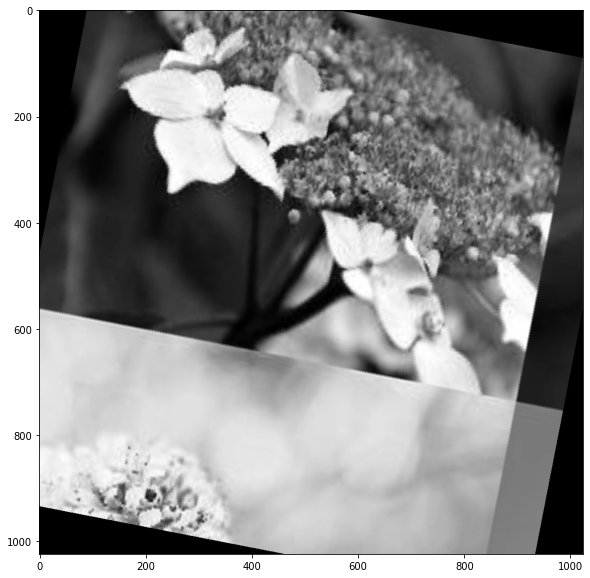

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))

plt.figure(figsize=(20,10))
plt.imshow(images[0].reshape((images[0].shape[1], images[0].shape[2])), cmap=plt.cm.gray)
images[0].min()